# Tarea 05 -  Aprendizaje maquina

## Giovanni Gamaliel López Padilla

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q tensorflow # Installs TF to environment

     |████████████████████████████████| 462 kB 6.8 MB/s 


In [ ]:
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding, Dropout, GlobalMaxPooling1D 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from numpy import array, asarray, zeros, argmax
from tensorflow.keras import Model
from argparse import Namespace
from typing import Callable
from os.path import join
import re

## Parametros

In [11]:
def get_params()->dict:
    params={
        "root": "/content/drive/MyDrive/Aprendizaje_maquina/Tareas/Tarea_05",
        "path data": "Data",
        "path models": "Models",
        "Glove file": "glove.6B.300d.txt",
        "word2vec file": "word2vec.txt",
        "data file": "eng_spa.txt",
    }
    params["path data"]=join(params["root"],
                             params["path data"])
    params["path models"]=join(params["root"],
                             params["path models"])
    return params

def get_args()->Namespace:
    args = Namespace()
    args.sentence_count=20000
    args.vocabulary_size=25000
    args.glove_embedding_size=300
    args.word2vec_embedding_size=300
    return args

## Glove y word2vec

In [4]:
class Glove_model:
    def __init__(self,params:dict)->None:
        self.params=params
        self._read()
    
    def _read(self)->None:
        filename = join(self.params["path data"],
                        self.params["Glove file"])
        self.embeddings_dict = dict()
        glove_file = open(filename)
        for line in glove_file:
            # Split de los valores
            records = line.split()
            # Primer valor es la palabra
            word = records[0]
            # Lo restante es el vector
            vector_dim = asarray(records[1:], 
                                 dtype='float32')
            # Se añade el embedding
            self.embeddings_dict[word] = vector_dim

class word2vec_model:
    def __init__(self,params:dict)->None:
        self.params=params
        self._read()
    
    def _read(self)->None:
        filename = join(self.params["path data"],
                        self.params["word2vec file"])
        self.embeddings_dict = dict()
        glove_file = open(filename)
        for line in glove_file:
            # Primer valor es la palabra
            records = line.split()
            word = records[0]
            # Lo restante es el vector
            vector_dim = asarray(records[1:], 
                                 dtype='float32')
            # Se añade el embedding
            self.embeddings_dict[word] = vector_dim

## Defincion de los datos

In [5]:
%tensorflow_version 2.x
class data_model:
    def __init__(self,params:dict,args:Namespace,Glove:Callable,word2vec:Callable)->None:
        self.params=params
        self.args=args
        self._read()
        self._tokenize()
        self._padding()
        self.create_dictionaries()
        self.create_embedding(Glove,
                              word2vec)
    
    def _read(self)->None:
        """
        Funcion que realiza la lectura de los datos de entrenamiento
        """
        # Nombre del archivo de datos
        filename = join(self.params["path data"],
                        self.params["data file"])
        # Inicializacion de las listas
        self.input_sentences = []
        self.input_translated_sentences = []
        self.output_translated_sentences = []
        count = 0
        for line in open(filename, encoding='utf-8'):
            if count < self.args.sentence_count:
                if '\t' in line:
                    # Remueve los espacios y signos de puntuacion
                    line = re.sub(r'[^\w\s]','', line)
                    # Primer entrada: ingles, segunda entrada: español
                    line_values = line.rstrip().split('\t')
                    self.input_sentences.append(line_values[1])
                    # Simbolos de inicio y final estan escritos en simbolos chinos
                    # Esto no crea una confusion en el tokenizer
                    input_translated_sentence = '走 ' + line_values[0]
                    output_translated_sentence = line_values[0] + ' 停'
                    # input_translated_sentence = '<s> ' + line_values[1]
                    # output_translated_sentence = line_values[1] + ' </s>'
                    self.input_translated_sentences.append(input_translated_sentence)
                    self.output_translated_sentences.append(output_translated_sentence)
                    count += 1
            else:
                break
    def _tokenize(self)->None:
        """
        Realiza la tokenizacion de las listas de datos
        """
        # Crea el tokenizador
        input_tokenizer = Tokenizer(num_words=self.args.vocabulary_size)
        # Tokenize la entrada
        input_tokenizer.fit_on_texts(self.input_sentences)
        # Extrae unicamente texto
        self.input_sequences = input_tokenizer.texts_to_sequences(self.input_sentences)
        # Obtiene un diccionadio de palabra indice
        self.word_index_dict = input_tokenizer.word_index
        # Conteo de palabras
        self.word_count = len(self.word_index_dict) + 1
        # Maximo de las secuencias de palabras
        self.max_input_length = max(len(seq) 
                                    for seq in self.input_sequences)
        output_tokenizer = Tokenizer(num_words=self.args.vocabulary_size)
        output_tokenizer.fit_on_texts(self.input_translated_sentences + self.output_translated_sentences)
        # Extrae unicamente texto
        self.input_translated_sequences = output_tokenizer.texts_to_sequences(self.input_translated_sentences)
        self.output_translated_sequences = output_tokenizer.texts_to_sequences(self.output_translated_sentences)
        # Obtiene un diccionadio de palabra indice
        self.translated_word_index_dict = output_tokenizer.word_index
        # Conteo de palabras
        self.translated_word_count = len(self.translated_word_index_dict) + 1
        # Maximo de las secuencias de palabras
        self.max_output_length = max([len(seq) 
                                        for seq in self.output_translated_sequences])
    
    def _padding(self)->None:
        """
        Crea una secuencia de vectores con un tamaño definido
        """
        self.encoder_input_sequences = pad_sequences(self.input_sequences, 
                                                     maxlen=self.max_input_length)
        self.decoder_input_sequences = pad_sequences(self.input_translated_sequences,
                                                     maxlen=self.max_output_length,
                                                     padding='post')
        self.decoder_output_sequences = pad_sequences(self.output_translated_sequences, 
                                                      maxlen=self.max_output_length, 
                                                      padding='post')
        self.decoder_targets_OHE = to_categorical(self.decoder_output_sequences,
                                                  num_classes=self.translated_word_count)
    
    def create_dictionaries(self)->None:
        """
        Creacion de los diccionarios de indice palabra para el input y output
        """
        self.index_word_dict = {i:w 
                           for w,i in self.word_index_dict.items()}
        self.index_translated_word_dict = {i:w 
                                      for w,i in self.translated_word_index_dict.items()}
    
    def create_embedding(self,Glove:Callable,word2vec:Callable)->None:
        """
        Creacion de las matrices de embeddings para el input y output basados en Glove y word2vec
        """
        # Numero de palabras definido por el vocabulario o el conteo de palabras encontradas
        self.word_count = min(self.args.vocabulary_size,
                              self.word_count)
        # Inicializacion de los embeddings de español
        self.word2vec_matrix = zeros((self.word_count,
                                   self.args.word2vec_embedding_size)) 
        # Rellenado del embedding
        for word, index in self.word_index_dict.items():
            # Peticion del vector de la palabra
            embeddings_vector = word2vec.embeddings_dict.get(word)
            if embeddings_vector is not None:
                self.word2vec_matrix[index] = embeddings_vector
        # Inicializacion de los embeddings de ingles
        self.glove_matrix = zeros((self.word_count,
                                      self.args.glove_embedding_size)) 
        for word, index in self.translated_word_index_dict.items():
            # Peticion del vector de la palabra
            embeddings_vector = Glove.embeddings_dict.get(word)
            if embeddings_vector is not None:
                self.glove_matrix[index] = embeddings_vector

## Modelo seq2seq

In [6]:
class seq2seq_model:
    def __init__(self,params:dict,args:Namespace)->None:
        self.params=params
        self.args=args
    
    def create(self,data_model:Callable)->None:
        # Encoder input layer 
        encoder_input = Input(shape=(data_model.max_input_length,), 
                              name='EncoderInput')
        # Incruste del word2vec embedding (español)
        encoder_input_x = Embedding(data_model.word_count,
                                self.args.word2vec_embedding_size,
                                weights=[data_model.word2vec_matrix],
                                input_length=data_model.max_input_length,
                                name='EncoderEmbeddingLayer')(encoder_input)
        # The encoder output and h/c states are extracted. h/c are used for the decoder.
        encoder_output, h, c = LSTM(1024, 
                                    return_state=True,
                                    name='EncoderLSTM')(encoder_input_x)
        encoder_states = [h, c]
        self.encoder_model = Model(encoder_input,
                                   encoder_states)
        # Decoder input layer
        decoder_input = Input(shape=(data_model.max_output_length,),
                              name='DecoderInput')
        # Incruste del Glove embeding (ingles)
        decoder_embedding = Embedding(data_model.word_count, 
                                      self.args.glove_embedding_size,
                                      weights=[data_model.glove_matrix],
                                      input_length=data_model.max_output_length,
                                      name='DecoderEmbeddingLayer')
        # The input is plugged into the embedding layer to receive "x".
        decoder_input_x = decoder_embedding(decoder_input)
        # The decoder LSTM is created and the "x" is plugged into it to receive the output.
        decoder_LSTM = LSTM(1024, 
                            return_state=True,
                            return_sequences=True,
                            name='DecoderLSTM')
        decoder_output, _, _ = decoder_LSTM(decoder_input_x,
                                            initial_state=encoder_states)
        # The decoder LSTM is also passed through dense layers for output predictions.
        decoder_dense = Dense(1024, activation='relu', 
                              name='DenseLayer') 
        decoder_dense_softmax = Dense(data_model.translated_word_count, 
                                      activation='softmax',
                                      name='DenseSoftmaxLayer')
        decoder_output = decoder_dense(decoder_output)
        decoder_output = decoder_dense_softmax(decoder_output)
        # Initial h/c input layers are generated and put into an array.
        decoder_state_input_h = Input(shape=(1024,), 
                                      name='InputHStep')
        decoder_state_input_c = Input(shape=(1024,),
                                      name='InputCStep')
        decoder_states_inputs = [decoder_state_input_h,
                                 decoder_state_input_c]

        # The decoder must accept a single word for the input layer as it loops through the sentence.
        decoder_input_step = Input(shape=(1,),
                                   name='DecoderInputStep')
        decoder_input_x_step = decoder_embedding(decoder_input_step)
        decoder_output_step, h, c = decoder_LSTM(decoder_input_x_step, 
                                                 initial_state=decoder_states_inputs)
        # The final states are put into an array.
        decoder_states = [h, c]
        # The decoder output for the step is put into two dense layers.
        decoder_output_step = decoder_dense(decoder_output_step)
        decoder_output_step = decoder_dense_softmax(decoder_output_step)
        # The decoder model is created.
        self.decoder_model = Model(
            # initial input step AND initial h/c layers 
            [decoder_input_step] + decoder_states_inputs,
            # output input step AND output h/c from decoder LSTM 
            [decoder_output_step] + decoder_states,
        )
        # Definicion del modelo
        self.model = Model([encoder_input,
                            decoder_input],
                           decoder_output)
        # Compilacion del modelo
        self.model.compile(
            optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
        # Train
        self.history = self.model.fit(
            [data_model.encoder_input_sequences, 
             data_model.decoder_input_sequences],
            data_model.decoder_targets_OHE,
            batch_size=16,
            epochs=10,
            validation_split=0.1)
        
    def translate_sentence(self,data_model:Callable,input_seq:str)->str:
        """
        Traduccion de una secuencia de palabras
        """
        # Devuelve el estado inicial del h/c que genera la secuencia de
        states_values = self.encoder_model.predict(input_seq)
        # Devuelve el primer token del indice del terget
        target_seq = zeros((1, 1))
        target_seq[0, 0] = data_model.translated_word_index_dict['走']
        # Asigna a una variable el termino de la ejecucion
        eos = data_model.translated_word_index_dict['停']
        # Inicializacion de la secuencia de salida
        output_sentence = []
        for _ in range(data_model.max_output_length):
            # Devuelve la prediccion de la secuencia 
            output_seq, h, c = self.decoder_model.predict([target_seq] + states_values)
            # Retorna el indice de la palabra con mayor probabilidad
            idx = argmax(output_seq[0, 0])
            # Si la palabra es igual entonces se detiene
            if eos == idx:
                break
            word = ''
            # Si el indice existe entonces se busca la palabra
            if idx > 0:
                word = data_model.index_translated_word_dict[idx]
                output_sentence.append(word)
            target_seq[0, 0] = idx
            states_values = [h, c]
        return ' '.join(output_sentence)

## Ejecucción

In [13]:
# Definicion de las rutas de los archivos
params=get_params()
# Definicion de los parametros
args = get_args()
# Carga de los embedding de Glove
glove=Glove_model(params)
# Carga de los embedding de word2vec
word2vec=word2vec_model(params)
# Lectura de los datos y creacion de los embeddings
data = data_model(params,
                  args,
                  glove,
                  word2vec)

In [14]:
# Creacion del modelo seq2seq
seq2seq=seq2seq_model(params,args)
seq2seq.create(data)

Epoch 1/10
1125/1125 [==============================] - 27s 17ms/step - loss: 2.2222 - accuracy: 0.6460 - val_loss: 2.3842 - val_accuracy: 0.6131
Epoch 2/10
1125/1125 [==============================] - 19s 17ms/step - loss: 1.6662 - accuracy: 0.7173 - val_loss: 2.2105 - val_accuracy: 0.6522
Epoch 3/10
1125/1125 [==============================] - 19s 17ms/step - loss: 1.4355 - accuracy: 0.7484 - val_loss: 2.0607 - val_accuracy: 0.6755
Epoch 4/10
1125/1125 [==============================] - 19s 17ms/step - loss: 1.2557 - accuracy: 0.7766 - val_loss: 1.9795 - val_accuracy: 0.6928
Epoch 5/10
1125/1125 [==============================] - 19s 17ms/step - loss: 1.1003 - accuracy: 0.8022 - val_loss: 1.9297 - val_accuracy: 0.7115
Epoch 6/10
1125/1125 [==============================] - 19s 17ms/step - loss: 0.9689 - accuracy: 0.8252 - val_loss: 1.8630 - val_accuracy: 0.7234
Epoch 7/10
1125/1125 [==============================] - 19s 17ms/step - loss: 0.8597 - accuracy: 0.8451 - val_loss: 1.9952 -

## Graficas

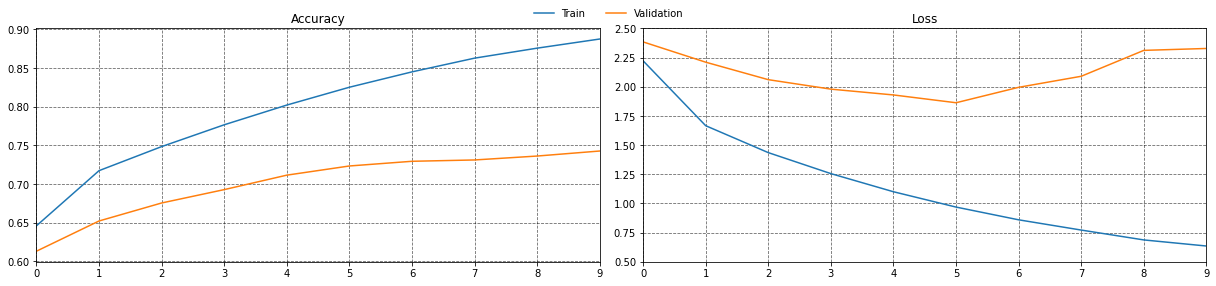

In [24]:
import matplotlib.pyplot as plt
fig,(ax1,ax2) = plt.subplots(1,2,
                 figsize = (17, 4),
                 sharex=True)
ax1.plot(seq2seq.history.history['accuracy'])
ax1.set_title('Accuracy')
ax1.plot(seq2seq.history.history['val_accuracy'])
ax1.set_xlim(0,9)
ax1.set_xticks(range(10))
ax2.plot(seq2seq.history.history['loss'], 
         label = 'Train')
ax2.plot(seq2seq.history.history['val_loss'],
         label = 'Validation')
ax2.set_ylim(0.5,2.5)
ax2.set_title('Loss')
ax1.grid(ls="--",
         alpha=0.6,
         color="#000000")
ax2.grid(ls="--",
         alpha=0.6,
         color="#000000")
fig.legend(loc="upper center",
           ncol=2,
           frameon=False)
plt.tight_layout()

## Prediccion

In [16]:
def prepare_sequence(data_model,sentence):
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence_array = sentence.rstrip().lower().split(' ')
    sentence_sequence = [data_model.word_index_dict[word] 
                         for word in sentence_array 
                         if word in data_model.word_index_dict.keys()]
    sentence_sequence = pad_sequences([sentence_sequence],
                                      maxlen=data_model.max_input_length)
    return sentence_sequence

In [28]:
sentences = [
    'Hola amigo', 
    "Que haces",
    "damelo",
    "vamos para el centro",
    "como estamos",
    "vamos a cambiarnos para alla"
]
for i, sentence in enumerate(sentences):
    input_sentence = prepare_sequence(sentence)
    translation = seq2seq.translate_sentence(data,
                                             input_sentence)
    print('Input:', sentence)
    print('Response:', translation)
    print('')

Input: Hola amigo
Response: hi

Input: Que haces
Response: do you understand

Input: damelo
Response: give them to me

Input: vamos para el centro
Response: lets go is i i we i

Input: como estamos
Response: were sorry

Input: vamos a cambiarnos para alla
Response: lets go



### Conclusiones

Algunas de las palabras obtenidas en los resultados obtenidos por el modelo tienen una semantica correcta. Aunque no sea una traducción palabra por palabra, el mensaje de la frase se mantiene en la traducción. El modelo basado en palabras no contiene errores ortograficos en comparación como puede pasar con el modelo basado en caracteres. Al realizar los tokens con palabras, los simbolos se ven perdidos en los resultados